In [18]:
import numpy as np
import matplotlib.pyplot as plt

import bilby
from bilby.core.prior import Uniform, PowerLaw, Sine
from bilby.gw.conversion import convert_to_lal_binary_black_hole_parameters, generate_all_bbh_parameters

from gwpy.timeseries import TimeSeries

In [2]:
# Trigger time of GW150914
time_of_event = 1126259462.4

### Set up empty interferometers

- 'Empty' means interferometers don't have strain data, but they know their orientations and locations.

- Empty setups can be used for __simulations__ or __noise analysis__, allowing to work with detectors' configuration before actual data is available or applied. It also __organizes the analysis pipeline__, letting the work with correct structure even if actual strain data isn't yet included.

In [3]:
H1 = bilby.gw.detector.get_empty_interferometer("H1")
L1 = bilby.gw.detector.get_empty_interferometer("L1")

In [4]:
# Definite times in relation to the trigger time (time_of_event), duration and post_trigger_duration
post_trigger_duration = 2
duration = 4
analysis_start = time_of_event + post_trigger_duration - duration

# Use gwpy to fetch the open data
H1_analysis_data = TimeSeries.fetch_open_data(
    "H1", analysis_start, analysis_start + duration, sample_rate=4096, cache=True)

L1_analysis_data = TimeSeries.fetch_open_data(
    "L1", analysis_start, analysis_start + duration, sample_rate=4096, cache=True)

In [5]:
# Initialise the Bilby interferometers with the strain data

H1.set_strain_data_from_gwpy_timeseries(H1_analysis_data)
L1.set_strain_data_from_gwpy_timeseries(L1_analysis_data)

In [6]:
# Download the PSD data using off-source data

psd_duration = duration * 32
psd_start_time = analysis_start - psd_duration

H1_psd_data = TimeSeries.fetch_open_data(
    "H1", psd_start_time, psd_start_time + psd_duration, sample_rate=4096, cache=True)

L1_psd_data = TimeSeries.fetch_open_data(
    "L1", psd_start_time, psd_start_time + psd_duration, sample_rate=4096, cache=True)

 Now use the standard `gwpy psd` method to calculate the PSD

 Here, `psd_alpha` variable is converting the `roll_off` applied to the strain data into the fractional value used by `gwpy`. This applies a window with an appropriate shape to the time-domain data.

 Note: roll-off refers to the gradual reduction in amplitude or energy of a signal as the frequency increases (tapering).

In [7]:
psd_alpha = 2 * H1.strain_data.roll_off / duration
H1_psd = H1_psd_data.psd(fftlength=duration, overlap=0, window=("tukey", psd_alpha), method="median")
L1_psd = L1_psd_data.psd(fftlength=duration, overlap=0, window=("tukey", psd_alpha), method="median")

In [8]:
# Initialise the PSD

H1.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(
    frequency_array=H1_psd.frequencies.value, psd_array=H1_psd.value)
L1.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(
    frequency_array=H1_psd.frequencies.value, psd_array=L1_psd.value)


<>:13: SyntaxWarning: invalid escape sequence '\s'
<>:13: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_1059/1145240886.py:13: SyntaxWarning: invalid escape sequence '\s'
  ax.set_ylabel("Strain [strain/$\sqrt{Hz}$]")


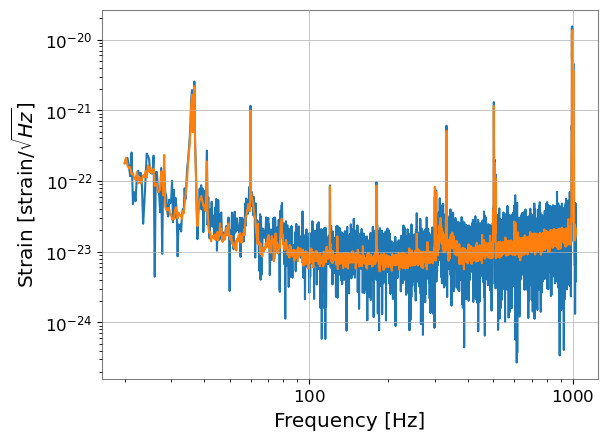

In [9]:
# Plot the amplitude spectral density (ASD), square root of the PSD
# which has right units to be comparable to the frequency-domain strain data.
H1.maximum_frequency = 1024
L1.maximum_frequency = 1024

fig, ax = plt.subplots()
idxs = H1.strain_data.frequency_mask  # This is a boolean mask of the frequencies which we'll use in the analysis
ax.loglog(H1.strain_data.frequency_array[idxs],
          np.abs(H1.strain_data.frequency_domain_strain[idxs]))
ax.loglog(H1.power_spectral_density.frequency_array[idxs],
          H1.power_spectral_density.asd_array[idxs])
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Strain [strain/$\sqrt{Hz}$]")
plt.show() 

### Low dimensional analysis

- In general, a compact binary coalescence signal is described by 15 parameters. 

- The goal of parameter estimation is to figure out what the data can tell us about the likely values of these parameters (posterior distribution of the parameters).

- To start, we'll analyse the data fixing all but a few of the parameters to known values (delta function priors are used in Bayesian inference).

- Inferences about $m_1$ and $m_2$ are highly correlated.

- !! Bayesian inference methods are powerful at figuring out highly correlated posteriors. When parameters are highly correlated, the posterior can have narrow, elongated regions which is difficult for sampling algorithms.

- We can help it along by sampling parameters which are not highly correlated. In particular, we define __chirp mass__ and __mass ratio__:


$$ \mathcal{M} = \frac{(m_1 m_2)^{3/5}}{(m_1 + m_2)^{1/5}} $$


$$ q = \frac{m_{2}}{m_1} $$

Here, we create a prior fixing everything except the chirp mass, mass ratio, phase and geocent_time to fixed values.


Phase gives the phase of the system, and geocent_time the time at which it merges referred to the centre of the Earth.

In [10]:
prior = bilby.core.prior.PriorDict()
prior['chirp_mass'] = Uniform(  name='chirp_mass',            minimum=25,          maximum=35, latex_label='$\mathcal{M}$')
prior['mass_ratio'] = Uniform(  name='mass_ratio',            minimum=0.5,        maximum=1, latex_label='$q$')
prior['phase'] = Uniform(       name="phase",                 minimum=0,          maximum=2*np.pi)
prior['geocent_time'] = Uniform(name="geocent_time",          minimum=time_of_event-0.1, maximum=time_of_event+0.1)
prior['a_1'] =  0
prior['a_2'] =  0
prior['tilt_1'] =  0
prior['tilt_2'] =  0
prior['phi_12'] =  0
prior['phi_jl'] =  0
prior['dec'] =  -1.2232
prior['ra'] =  2.19432
prior['theta_jn'] =  1.89694
prior['psi'] =  0.532268
prior['luminosity_distance'] = PowerLaw(alpha=2, name='luminosity_distance', minimum=50, maximum=2000, unit='Mpc', latex_label='$d_L$')


<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_1059/1303897380.py:2: SyntaxWarning: invalid escape sequence '\m'
  prior['chirp_mass'] = Uniform(  name='chirp_mass',            minimum=25,          maximum=35, latex_label='$\mathcal{M}$')


### Create a likelihood

In [11]:
# First, put our "data" created above into a list of interferometers (the order is arbitrary)
interferometers = [H1, L1]

# Next create a dictionary of arguments which we pass into the LALSimulation waveform - we specify the waveform approximant here
waveform_arguments = dict(
    waveform_approximant='IMRPhenomXP', reference_frequency=100., catch_waveform_errors=True)

# Next, create a waveform_generator object. This wraps up some of the jobs of converting between parameters etc
waveform_generator = bilby.gw.WaveformGenerator(
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    waveform_arguments=waveform_arguments,
    parameter_conversion=convert_to_lal_binary_black_hole_parameters)

# Finally, create our likelihood, passing in what is needed to get going
likelihood = bilby.gw.likelihood.GravitationalWaveTransient(
    interferometers, waveform_generator, priors=prior,
    time_marginalization=True, phase_marginalization=True, distance_marginalization=True)

00:23 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
00:23 bilby INFO    : Loaded distance marginalisation lookup table from .distance_marginalization_lookup.npz.


Note that we also specify `time_marginalization=True`, `phase_marginalization=True`, and `distance_marginalization=True`. This is a trick often used in Bayesian inference. We analytically marginalize (integrate) over the time/phase of the system while sampling, effectively reducing the parameter space and making it easier to sample. Bilby will then figure out (after the sampling) posteriors for these marginalized parameters.

In [12]:
# Run the analysis

result_short = bilby.run_sampler(
        likelihood,
        prior,
        sampler='dynesty', 
        outdir='short', 
        label="GW150914",
        conversion_function=bilby.gw.conversion.generate_all_bbh_parameters,
        nlive=250,
        dlogz=1.,  # <- Arguments are used to make things fast - not recommended for general use
        clean=True,
)

00:23 bilby INFO    : Running for label 'GW150914', output will be saved to 'short'
00:23 bilby INFO    : Using lal version 7.5.0
00:23 bilby INFO    : Using lal git version Branch: None;Tag: lal-v7.5.0;Id: edd3f4e61431c1a0c6a7be13c0be9644be1f6745;;Builder: Unknown User <>;Repository status: CLEAN: All modifications committed
00:23 bilby INFO    : Using lalsimulation version 5.4.0
00:23 bilby INFO    : Using lalsimulation git version Branch: None;Tag: lalsimulation-v5.4.0;Id: 57c31779c344c6abf3c1d294bab00dd58ed17875;;Builder: Unknown User <>;Repository status: CLEAN: All modifications committed
00:23 bilby INFO    : Analysis priors:
00:23 bilby INFO    : chirp_mass=Uniform(minimum=25, maximum=35, name='chirp_mass', latex_label='$\\mathcal{M}$', unit=None, boundary=None)
00:23 bilby INFO    : mass_ratio=Uniform(minimum=0.5, maximum=1, name='mass_ratio', latex_label='$q$', unit=None, boundary=None)
00:23 bilby INFO    : time_jitter=Uniform(minimum=-0.000244140625, maximum=0.000244140625,

1it [00:00, ?it/s]

00:24 bilby INFO    : Written checkpoint file short/GW150914_resume.pickle
00:35 bilby INFO    : Written checkpoint file short/GW150914_resume.pickle
00:40 bilby INFO    : Written checkpoint file short/GW150914_resume.pickle
00:40 bilby INFO    : Rejection sampling nested samples to obtain 298 posterior samples
00:40 bilby INFO    : Sampling time: 0:17:05.411917


00:40 bilby INFO    : Computing per-detector log likelihoods.


  0%|          | 0/298 [00:00<?, ?it/s]

00:41 bilby INFO    : Reconstructing marginalised parameters.


  0%|          | 0/298 [00:00<?, ?it/s]

00:41 bilby INFO    : Generating sky frame parameters.


  0%|          | 0/298 [00:00<?, ?it/s]

00:41 bilby INFO    : Computing SNRs for every sample.


  0%|          | 0/298 [00:00<?, ?it/s]

00:41 bilby INFO    : Summary of results:
nsamples: 298
ln_noise_evidence: -8534.562
ln_evidence: -8251.468 +/-  0.258
ln_bayes_factor: 283.093 +/-  0.258



Posterior samples are stored in a pandas data frame

In [13]:
result_short.posterior

,chirp_mass,mass_ratio,time_jitter,phase,geocent_time,a_1,a_2,tilt_1,tilt_2,phi_12,...,chi_2_in_plane,chi_p,cos_tilt_1,cos_tilt_2,redshift,comoving_distance,mass_1_source,mass_2_source,chirp_mass_source,total_mass_source
0,30.291849,0.775603,0.000083,1.740817,1.126259e+09,0,0,0,0,0,...,0.0,0.0,1.0,1.0,0.061936,270.126730,37.266014,28.903619,28.525112,66.169632
1,30.138399,0.709286,0.000131,4.799038,1.126259e+09,0,0,0,0,0,...,0.0,0.0,1.0,1.0,0.060771,265.119613,38.865899,27.567022,28.411782,66.432922
2,30.793060,0.640333,0.000141,4.521506,1.126259e+09,0,0,0,0,0,...,0.0,0.0,1.0,1.0,0.060440,263.693988,41.889932,26.823525,29.038016,68.713457
3,30.941597,0.671242,0.000211,1.308929,1.126259e+09,0,0,0,0,0,...,0.0,0.0,1.0,1.0,0.063117,275.197317,40.967750,27.499280,29.104609,68.467030
4,30.442788,0.628567,-0.000148,4.477868,1.126259e+09,0,0,0,0,0,...,0.0,0.0,1.0,1.0,0.059175,258.254113,41.866519,26.315928,28.741989,68.182448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293,31.081625,0.894843,-0.000107,1.443009,1.126259e+09,0,0,0,0,0,...,0.0,0.0,1.0,1.0,0.063236,275.707412,35.509189,31.775151,29.233056,67.284340
294,31.137590,0.977942,-0.000124,1.511676,1.126259e+09,0,0,0,0,0,...,0.0,0.0,1.0,1.0,0.066199,288.423358,33.923565,33.175277,29.204288,67.098841
295,31.072825,0.987083,-0.000029,4.773707,1.126259e+09,0,0,0,0,0,...,0.0,0.0,1.0,1.0,0.064009,279.029249,33.764960,33.328827,29.203527,67.093787
296,31.042140,0.997103,-0.000061,4.709033,1.126259e+09,0,0,0,0,0,...,0.0,0.0,1.0,1.0,0.067873,295.595432,33.440143,33.343281,29.069137,66.783425


In [14]:
# for specific parameters (pandas)

result_short.posterior["chirp_mass"]

# if we want to get the numbers as numpy array

Mc = result_short.posterior["chirp_mass"].values

We can then get some useful quantities such as the 90% credible interval.

In [15]:
lower_bound = np.quantile(Mc, 0.05)
upper_bound = np.quantile(Mc, 0.95)
median = np.quantile(Mc, 0.5)
print("Mc = {} with a 90% C.I = {} -> {}".format(median, lower_bound, upper_bound))

Mc = 30.979389605419506 with a 90% C.I = 30.5426599473799 -> 31.43676040431755


We can plot the chirp mass in a histogram adding a region to indicate the 90% credible interval

<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:5: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_1059/3522868616.py:5: SyntaxWarning: invalid escape sequence '\m'
  ax.set_xlabel("$\mathcal{M}_{\odot}$")


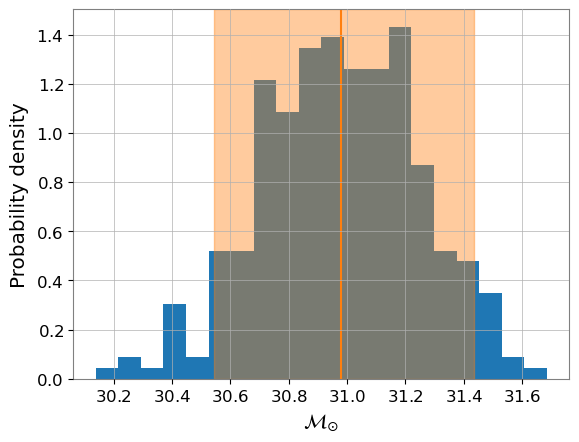

In [19]:
fig, ax = plt.subplots()
ax.hist(result_short.posterior["chirp_mass"], bins=20, density=True)
ax.axvspan(lower_bound, upper_bound, color='C1', alpha=0.4)
ax.axvline(median, color='C1')
ax.set_xlabel("$\mathcal{M}_{\odot}$")
ax.set_ylabel("Probability density")
plt.show()

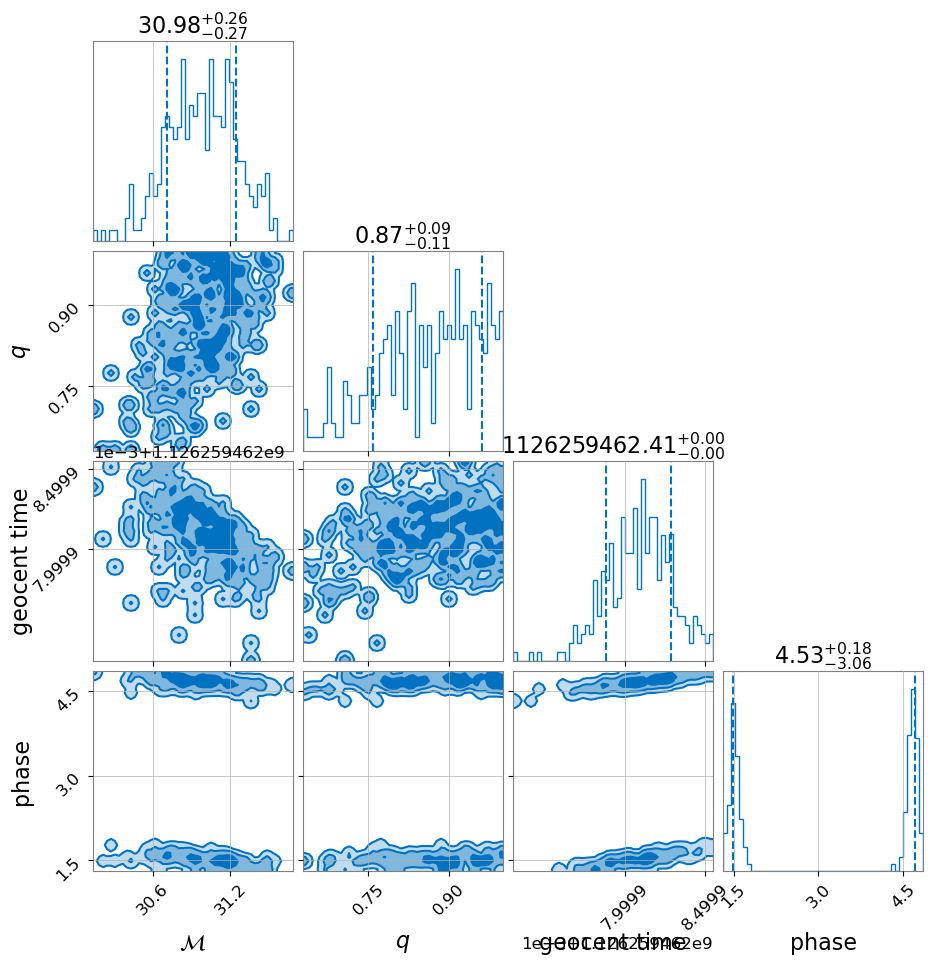

In [17]:
result_short.plot_corner(parameters=["chirp_mass", "mass_ratio", "geocent_time", "phase"], prior=True)